# Blood cell images
---
Read [homepage](https://www.kaggle.com/datasets/paultimothymooney/blood-cells) for more info.  
From my understanding, dataset2-master is intended to classify the type of blood cell while dataset-master is intended to detect cells locations with bounding boxes.

### Imports

In [1]:
from   collections import OrderedDict
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_rows', 50)
from PIL import Image
import plotly.express as px
import torch
assert torch.cuda.device_count() == 1, "Select GPU P100 in Settings > Accelerator from the right panel."
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# import torchvision
# from torchvision import transforms as T
# from torchvision.datasets import ImageFolder
# from torchvision.utils import draw_bounding_boxes
# from torchvision.io import read_image
import xml.etree.ElementTree as ET

# same bug as torchvision (cannot be imported before torchvision)
# from torchmetrics.classification import MulticlassConfusionMatrix

!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-68f51ca5-06b0-299c-2090-f47eba29e793)


### Dataset analysis

In [2]:
dataset_master = Path("../input/blood-cells/dataset-master/dataset-master/")
dataset2_master = Path("../input/blood-cells/dataset2-master/dataset2-master/images/")

dataset_csv = pd.read_csv(dataset_master/"labels.csv")

In [3]:
xml_files = set(path.stem for path in dataset_master.rglob("*.xml"))
jpg_files = set(path.stem for path in dataset_master.rglob("*.jpg"))
valid_stems = sorted(xml_files.intersection(jpg_files))

df = pd.DataFrame(((dataset_master/"JPEGImages"/(stem+".jpg"), dataset_master/"Annotations"/(stem+".xml")) for stem in valid_stems),
                 columns=["image", "annotation"])

In [4]:
df2 = pd.DataFrame(((*path.parts[-3:], path) for path in dataset2_master.rglob("*jpeg")),
                   columns=["subset", "cell_type", "filename", "path"])

In [6]:
with pd.option_context('display.float_format', lambda x: f"{x:.2%}"):
    print(df2["subset"].value_counts(normalize=True))

TRAIN         79.56%
TEST          19.87%
TEST_SIMPLE    0.57%
Name: subset, dtype: float64


In [7]:
df2.groupby(["cell_type", "subset"]).size().unstack()

subset,TEST,TEST_SIMPLE,TRAIN
cell_type,,,
EOSINOPHIL,623,13,2497
LYMPHOCYTE,620,6,2483
MONOCYTE,620,4,2478
NEUTROPHIL,624,48,2499


In [8]:
len(df2)

12515

### Visualization

In [9]:
df2.sample()

,subset,cell_type,filename,path
7744,TRAIN,LYMPHOCYTE,_10_6292.jpeg,../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_10_6292.jpeg


In [ ]:
# get random sample
img, xml = df.sample().values.flatten()

root = ET.parse(xml).getroot()

boxes = torch.tensor([[int(box.find(pos).text) for pos in ["xmin", "ymin", "xmax", "ymax"]] for box in root.findall(".//bndbox")])

result = draw_bounding_boxes(read_image(str(img)), boxes, colors=["yellow"]*len(boxes), width=4)

plt.imshow(result.permute((1,2,0)))
# plt.set_title()
plt.axis('off')
plt.show()


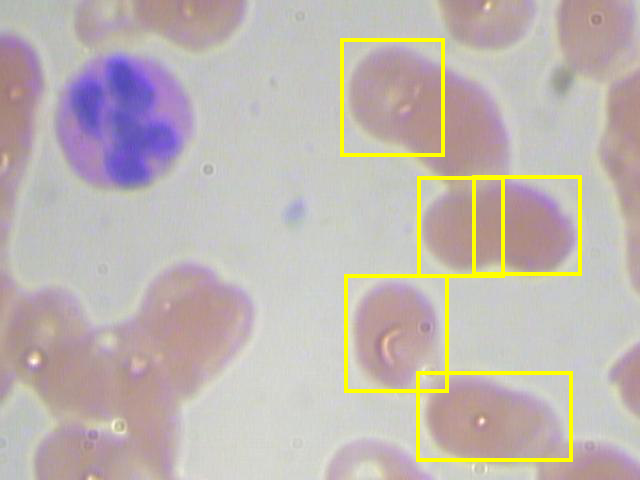

In [12]:
fig = px.imshow(result.permute((1,2,0)))
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

In [15]:
# cat $sample | head -30

### Model

In [7]:
# model_name = 'densenet121'
model_name = "efficientnet_b4"
model = torch.hub.load('pytorch/vision', model_name, weights="DEFAULT")
# weight_enum = torch.hub.load("pytorch/vision", "get_model_weights", name="densenet121")
# print([weight for weight in weight_enum])

for param in model.parameters():
    param.requires_grad = True

# # last layer de efficientnet_b7
# model.classifier = nn.Sequential(OrderedDict([
#     ('fcl1', nn.Linear(1024,256)),
#     ('dp1', nn.Dropout(0.3)),
#     ('r1', nn.ReLU()),
#     ('fcl2', nn.Linear(256,32)),
#     ('dp2', nn.Dropout(0.3)),
#     ('r2', nn.ReLU()),
#     ('fcl3', nn.Linear(32,4)),
# ]))

model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(1792,256)),
    ('dp1', nn.Dropout(0.3)),
    ('r1', nn.ReLU()),
    ('fcl2', nn.Linear(256,32)),
    ('dp2', nn.Dropout(0.3)),
    ('r2', nn.ReLU()),
    ('fcl3', nn.Linear(32,4)),
]))

print(f"before: {next(model.parameters()).device}")
device = torch.device("cuda")
model.to(device)
print(f"after: {next(model.parameters()).device}")

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


before: cpu
after: cuda:0


In [8]:
import torchvision
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, draw_bounding_boxes
from torchvision.io import read_image, ImageReadMode

from torchmetrics.classification import MulticlassConfusionMatrix

### Datasets and dataloaders

In [9]:
transform = T.Compose([
    # pas besoin de resize elles ont toutes les memes dimensions
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_data = ImageFolder(root=dataset2_master/"TRAIN", transform=transform)
train_loader = DataLoader(
    train_data,
    batch_size=32,
    num_workers=2,
    shuffle=True,
)

val_data = ImageFolder(root=dataset2_master/"TEST_SIMPLE", transform=transform)
val_loader = DataLoader(
    val_data,
    batch_size=16,
    num_workers=2,
    shuffle=False,
)

### Training

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters())

In [15]:
epochs = 5
for epoch in range(1, epochs+1):
    train_loss = 0
    nb_train_batches = len(train_loader)
    model.train()
    for batch, (data, target) in enumerate(train_loader):
        print(f"[Epoch {epoch:>2}] Train batch progress: {batch+1:>3}/{nb_train_batches}", end='\r')
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = loss_fn(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    
    val_loss = 0
    nb_val_batches = len(val_loader)
    val_acc = 0
    model.eval()
    with torch.no_grad():
        for batch, (data, target) in enumerate(val_loader):
            print(f"[Epoch {epoch:>2}] Val batch progress: {batch+1:>3}/{nb_val_batches}", end='\r')
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            val_loss += loss.item() * data.size(0)
            _, preds = torch.max(output, 1)
            val_acc += (preds == target).float().sum()
        
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
    print(f"[Epoch {epoch:>2}] Train loss: {train_loss:.5f} | Val loss: {val_loss:.6f} | Val accuracy: {val_acc:.2%}")

[Epoch  1] Train loss: 0.00519 | Val loss: 1.047553 | Val accuracy: 92.96%
[Epoch  2] Train loss: 0.00490 | Val loss: 1.210312 | Val accuracy: 91.55%
[Epoch  3] Train loss: 0.00683 | Val loss: 1.195829 | Val accuracy: 91.55%
[Epoch  4] Train loss: 0.00399 | Val loss: 1.321919 | Val accuracy: 90.14%
[Epoch  5] Train loss: 0.00399 | Val loss: 1.511943 | Val accuracy: 92.96%


In [16]:
test_data = ImageFolder(root=dataset2_master/"TEST", transform=transform)
test_loader = DataLoader(
    test_data,
    batch_size=32,
    num_workers=2,
    shuffle=False,
)

In [17]:
test_loss = 0
nb_test_batches = len(test_loader)
test_acc = 0
metric = MulticlassConfusionMatrix(num_classes=4).to(device)
model.eval()
with torch.no_grad():
    for batch, (data, target) in enumerate(test_loader):
        print(f"[Epoch {epoch:>2}] Val batch progress: {batch+1:>3}/{nb_test_batches}", end='\r')
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = loss_fn(output, target)
        test_loss += loss.item() * data.size(0)
        _, preds = torch.max(output, 1)
        test_acc += (preds == target).float().sum()
        metric.update(preds, target)

test_loss /= len(test_loader.dataset)
test_acc /= len(test_loader.dataset)
print(f"test loss: {test_loss:.6f} | test accuracy: {test_acc:.2%}                             ")

test loss: 1.889855 | test accuracy: 87.90%                             


In [18]:
metric.compute()

tensor([[502,  18,   0, 103],
        [  0, 620,   0,   0],
        [  0,   0, 465, 155],
        [ 25,   0,   0, 599]], device='cuda:0')

In [57]:
train_data.classes
train_data.class_to_idx

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']